Now in FinalProject/
Files: ['spark-46877704.err', 'pipeline.ipynb', 'tweets_with_topics_v2_flat.csv', 'SPX_full_5min_with_datetime_parts.csv', 'spark-46905470.out', 'standalone (1).sh', 'spark-46905470.err', 'pipeline.py', 'test (1).py', 'spark-46877704.out', 'SecureW2.mobileconfig']
Matched tweet events: 11885


/tmp/ipython-input-262248104.py:112: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.pointplot(
/tmp/ipython-input-262248104.py:112: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  sns.pointplot(
/tmp/ipython-input-262248104.py:112: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.5}` instead.

  sns.pointplot(


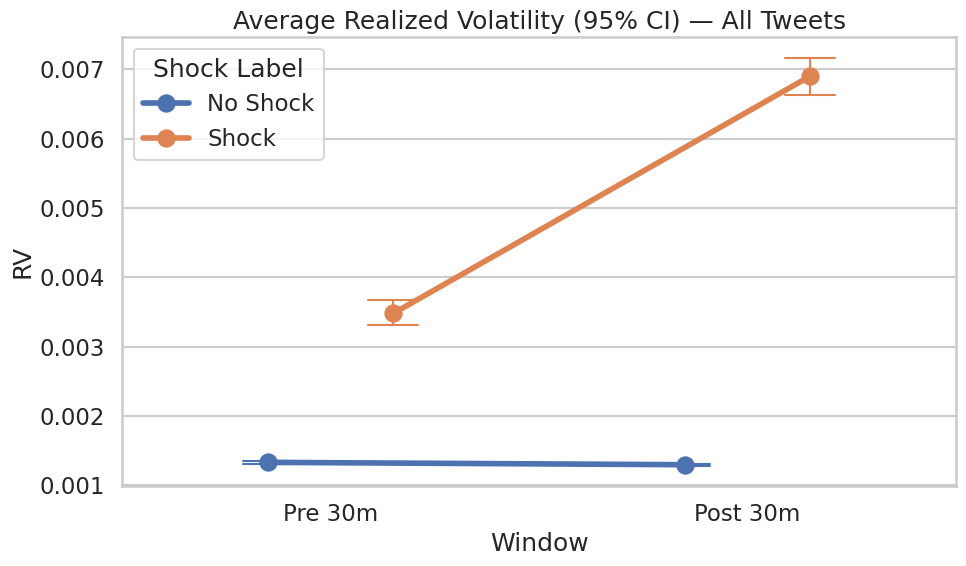

High-Intensity sample: 1461


/tmp/ipython-input-262248104.py:145: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.pointplot(
/tmp/ipython-input-262248104.py:145: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  sns.pointplot(
/tmp/ipython-input-262248104.py:145: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.5}` instead.

  sns.pointplot(


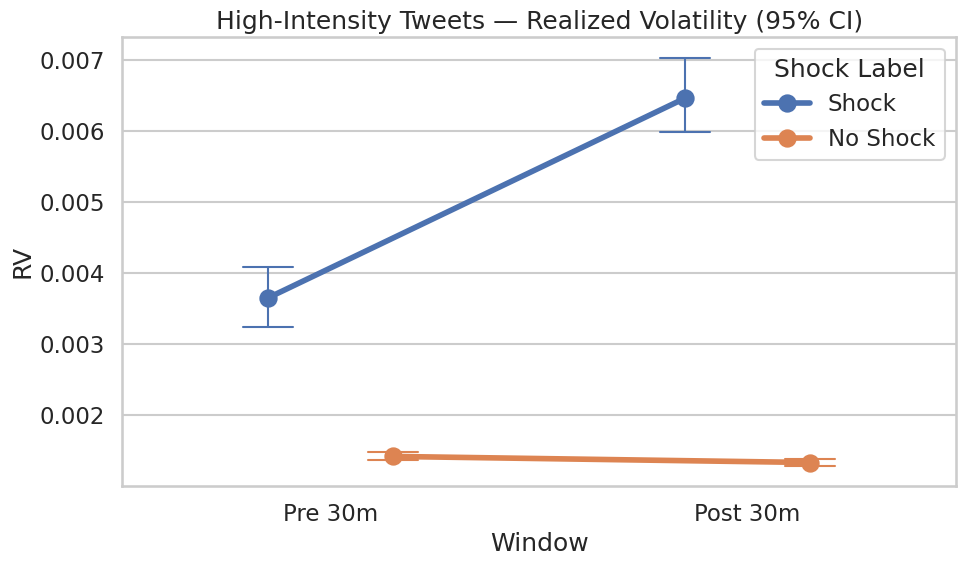

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


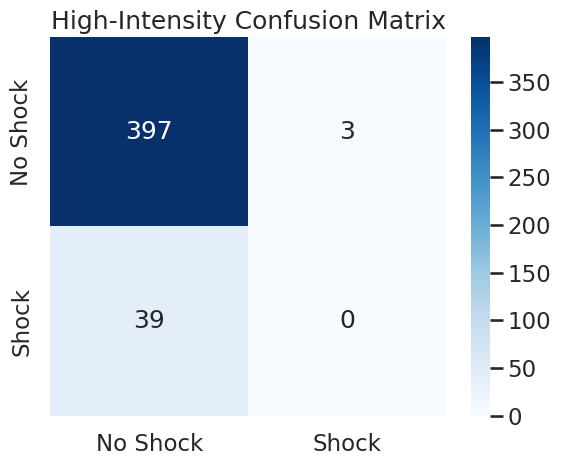

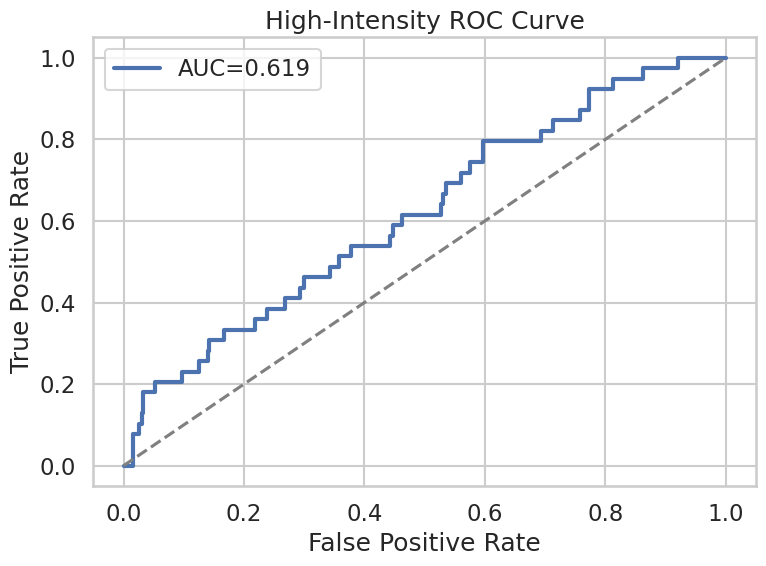

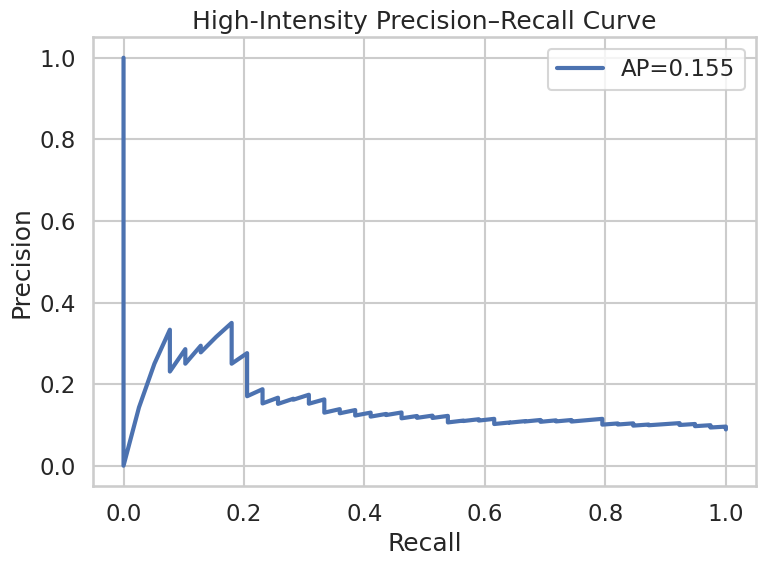


✓ ALL high-intensity visuals and improved volatility visual generated!
Saved to FinalProject/visualizations/


In [21]:
# ====================================================================
# Rebuild events + ALL FOUR high-intensity visuals + improved RV visual
# ====================================================================

!pip install -q pandas numpy matplotlib seaborn scikit-learn

import os, zipfile
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, roc_curve, roc_auc_score,
    precision_recall_curve, average_precision_score,
    accuracy_score, f1_score
)

sns.set_theme(style="whitegrid", context="talk")

# ================================================================
# 1. Extract ZIP if needed, then cd into FinalProject
# ================================================================
if "FinalProject" not in os.listdir():
    for f in os.listdir():
        if f.endswith(".zip") and "FinalProject" in f:
            with zipfile.ZipFile(f, "r") as z:
                z.extractall()
            break

os.chdir("FinalProject")
print("Now in FinalProject/")
print("Files:", os.listdir())

# ================================================================
# 2. Load Data
# ================================================================
spx = pd.read_csv("SPX_full_5min_with_datetime_parts.csv")
tweets = pd.read_csv("tweets_with_topics_v2_flat.csv")

# Build timestamps
spx["bar_time"] = pd.to_datetime(dict(
    year=spx.year, month=spx.month, day=spx.day,
    hour=spx.hour, minute=spx.minute, second=spx.second
))

tweets["tweet_time"] = pd.to_datetime(dict(
    year=tweets.year, month=tweets.month, day=tweets.day,
    hour=tweets.hour, minute=tweets.minute, second=tweets.second
))

# Add text features
tweets["text_length"] = tweets["text"].astype(str).str.len()
tweets["exclamation_count"] = tweets["text"].astype(str).str.count("!")

# ================================================================
# 3. Build Realized Volatility (pre/post 30m)
# ================================================================
spx["log_return"] = np.log(spx["Close"] / spx["Close"].shift(1))

spx["rv_pre_30m"] = (
    spx["log_return"].rolling(6).apply(lambda x: np.sqrt(np.sum(x**2)), raw=True)
)

spx["rv_post_30m"] = (
    spx["log_return"].shift(-6).rolling(6).apply(lambda x: np.sqrt(np.sum(x**2)), raw=True)
)

# ================================================================
# 4. Match tweets to nearest SPX bar (±10 min)
# ================================================================
merged = tweets.merge(spx, on=["year","month","day"])
merged["time_diff_sec"] = (merged["bar_time"] - merged["tweet_time"]).abs().dt.total_seconds()

events = (
    merged[merged["time_diff_sec"] <= 600]
    .sort_values(["id","time_diff_sec"])
    .groupby("id")
    .head(1)
)

print("Matched tweet events:", len(events))

# ================================================================
# 5. Label shocks = top 10% RV_post_30m
# ================================================================
threshold = events["rv_post_30m"].quantile(0.90)
events["is_shock"] = (events["rv_post_30m"] > threshold).astype(int)

os.makedirs("visualizations", exist_ok=True)

# ====================================================================
# PART A — Improved Volatility Visual (All Tweets)
# ====================================================================

vol_long = events[["is_shock","rv_pre_30m","rv_post_30m"]].melt(
    id_vars="is_shock",
    var_name="Window",
    value_name="RV"
)

vol_long["Shock Label"] = vol_long["is_shock"].map({0:"No Shock", 1:"Shock"})
vol_long["Window"] = vol_long["Window"].map({
    "rv_pre_30m":"Pre 30m",
    "rv_post_30m":"Post 30m"
})

plt.figure(figsize=(10,6))
sns.pointplot(
    data=vol_long,
    x="Window", y="RV",
    hue="Shock Label",
    dodge=0.3, join=True,
    estimator=np.mean, ci=95,
    markers="o", capsize=0.12, errwidth=1.5
)
plt.title("Average Realized Volatility (95% CI) — All Tweets")
plt.tight_layout()
plt.savefig("visualizations/volatility_improved_all.png", dpi=300)
plt.show()

# ====================================================================
# PART B — High-Intensity Tweets Only
# ====================================================================
events_high = events[events["intensity"] == "High"].copy()
print("High-Intensity sample:", len(events_high))

# ---- High-Intensity Volatility Visual ----
vol_hi = events_high[["is_shock","rv_pre_30m","rv_post_30m"]].melt(
    id_vars="is_shock",
    var_name="Window",
    value_name="RV"
)

vol_hi["Shock Label"] = vol_hi["is_shock"].map({0:"No Shock",1:"Shock"})
vol_hi["Window"] = vol_hi["Window"].map({
    "rv_pre_30m":"Pre 30m",
    "rv_post_30m":"Post 30m"
})

plt.figure(figsize=(10,6))
sns.pointplot(
    data=vol_hi,
    x="Window", y="RV",
    hue="Shock Label",
    dodge=0.3, join=True,
    estimator=np.mean, ci=95,
    markers="o", capsize=0.12, errwidth=1.5
)
plt.title("High-Intensity Tweets — Realized Volatility (95% CI)")
plt.tight_layout()
plt.savefig("visualizations/volatility_high_intensity.png", dpi=300)
plt.show()

# ====================================================================
# PART C — ML Setup for High-Intensity Tweets
# ====================================================================
cat_cols = ["category","blue_category","sentiment","intensity"]
num_cols = ["rv_pre_30m","Close","favorites","retweets",
            "text_length","exclamation_count"]

events_high[num_cols] = events_high[num_cols].fillna(0)
events_high[cat_cols] = events_high[cat_cols].fillna("Unknown")

df_hi = pd.get_dummies(events_high[["is_shock"] + cat_cols + num_cols], drop_first=True)

X_hi = df_hi.drop(columns=["is_shock"])
y_hi = df_hi["is_shock"]

Xh_train, Xh_test, yh_train, yh_test = train_test_split(
    X_hi, y_hi, test_size=0.3, random_state=42
)

clf_hi = LogisticRegression(max_iter=2000)
clf_hi.fit(Xh_train, yh_train)

yh_pred = clf_hi.predict(Xh_test)
yh_prob = clf_hi.predict_proba(Xh_test)[:,1]

# ====================================================================
# PART D — Confusion Matrix (High-Intensity)
# ====================================================================
cm_hi = confusion_matrix(yh_test, yh_pred)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm_hi, annot=True, fmt="d", cmap="Blues",
    xticklabels=["No Shock","Shock"],
    yticklabels=["No Shock","Shock"]
)
plt.title("High-Intensity Confusion Matrix")
plt.tight_layout()
plt.savefig("visualizations/confusion_high_intensity.png", dpi=300)
plt.show()

# ====================================================================
# PART E — ROC Curve (High-Intensity)
# ====================================================================
fpr_hi, tpr_hi, _ = roc_curve(yh_test, yh_prob)
roc_auc_hi = roc_auc_score(yh_test, yh_prob)

plt.figure(figsize=(8,6))
plt.plot(fpr_hi, tpr_hi, linewidth=3, label=f"AUC={roc_auc_hi:.3f}")
plt.plot([0,1],[0,1],'--',color="gray")
plt.title("High-Intensity ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.tight_layout()
plt.savefig("visualizations/roc_high_intensity.png", dpi=300)
plt.show()

# ====================================================================
# PART F — PR Curve (High-Intensity)
# ====================================================================
precision_hi, recall_hi, _ = precision_recall_curve(yh_test, yh_prob)
pr_auc_hi = average_precision_score(yh_test, yh_prob)

plt.figure(figsize=(8,6))
plt.plot(recall_hi, precision_hi, linewidth=3, label=f"AP={pr_auc_hi:.3f}")
plt.title("High-Intensity Precision–Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.tight_layout()
plt.savefig("visualizations/pr_high_intensity.png", dpi=300)
plt.show()

print("\n✓ ALL high-intensity visuals and improved volatility visual generated!")
print("Saved to FinalProject/visualizations/")
